In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, interp1d
from IPython.display import clear_output

from utils_plot_iso_T3T1 import p_over_pt_from_M, mass_flow_per_area_from_M, M_from_p_over_pt
import os

# Data processing pipeline

**GOAL**: The final purpose of this notebook is computing the iso-$T_3^0 / T_1^0$ contour lines on the Compressor map. These lines naturally arise from the matching of the Compressor, Turbine and Nozzle working points. Mathematically speaking, this matching comes from the application of the following equations:

- _Mass conservation_ : $ \dot m \frac{\sqrt{\theta_3}}{\delta_3} = \dot m \frac{\sqrt{\theta_1}}{\delta_1}\sqrt{\frac{T_3^0}{T_1^0}} \frac{p_1^0}{p_2^0} \frac{p_2^0}{p_3^0} \implies \dot m_{corr, T} = \dot m_{corr, C} \sqrt{\frac{T_3^0}{T_1^0}}\frac{1}{PR_c \cdot \varepsilon_b}$ 

- _Spool speed congruence_: $\frac{N}{\sqrt{\theta_3}} = \frac{N}{\sqrt{\theta_1}} \sqrt{\frac{T_1^0}{T_3^0}} \implies N_{corr, T} = N_{corr, C} \sqrt{\frac{T_1^0}{T_3^0}}$

And the verification of the following one:

- _Pressure congurence_: $\left( 1 + \frac{\gamma - 1}{2} M_0 ^ 2 \right)^{\frac{\gamma}{\gamma - 1}} \varepsilon_d PR_c = \frac{PR_t PR_n}{\varepsilon_b}$

## Components maps

Overall, the Turbojet engine is constituted (according to the 0th order model) by:

Air Intake -> Compressor -> Combustor -> Turbine -> Nozzle

In principle, each component should be characterized by it's own specific map, collecting all the steady-state working points. However, for the sake of simplicity, we will refer only to the maps of the Compressor and the Turbine (as extracted from the GSP 11 software), and will calculate from scratch the Nozzle map from gasdynamic considerations.

To unequivocally determine a point on the Compressor and Turbine map we need to set 4 parameters:

- $N_{corr}$: Corrected spool speed (speed)
- $\dot m_{corr}$: Corrected mass flow (mf)
- $PR$ : Pressure ratio (we want to use numbers greater than one, so for the turbine is $p_{in} / p_{out}$ while for the compressor we have $p_{out} / p_{in}$)
- $\eta$: Adiabatic efficiency (eff) of the component
- $\beta$: Jolly parameter; this parameter is theoretically non necessary, but is given as an additional information to avoid numerical instabilities close to nearly horizontal or nearly vertical curves. The $\beta$ parameter is defined in such a way that it is perpendicular to these critical regions, allowing for correct points definition. 

For the compressor the relation between $\beta$ and $PR_c$ must be inferred numerically, while for the turbine it is readily available as $\beta$ has been defined in this case as a simple linear mapping of the type:

$PR_t \in [(PR_t)_{min}, (PR_t)_{max} \rightarrow \beta \in [0, 1]$

Once this operation has been performed, we can correctly store the information regarding the component steady-state working points as follows:


- 1 vector storing the PR abscissae with arbitrary length, and with extremes $PR_{min}$ and $PR_{max}$
- 1 vector storing the N parameter with arbitrary length, and with extremes $N_{min}$ and $N_{max}$
- 1 matrix storing the mf values with shape: len(speed) x len(PR)
- 1 matrix storing the eff values with shape: len(speed) x len(PR)

Before proceeding to the computation of the $T_3^0/T_1^0$ values, we need to match the turbine with the nozzle map, obtaining a combined map. This new map can be seen as a new component, which we will refer to as Turbnozz. The turbnozz working point is defined by the following set of structures:

- 1 vector storing the N parameter with the same length and values from the input N of the turbine
- 1 vector storing the PR parameter: this $PR_{tn} = PR_t \cdot PR_n$. To correctly calculate this vector we need to ensure that PR_t and PR_n have the same length, but not the same bounds.
- 1 matrix storing the mf parameter: this matrix describes the corrected mass flow passing through turbine and nozzle for each N (row). This value may be affected both by the choking of the Nozzle or of the Turbine
- 1 matrix storing the eff parameter: this matrix is unchanged from the N turbine, as the nozzle is assumed to be adiabatic and isentropic. 

Since we want to determine the correct $T_3^0/T_1^0$ for each point by enforcing the already stated congruence equations, numerically speaking the equations become:

- $ \tilde{\dot m}_{corr, T} = \dot m_{corr, C}[i, j] \sqrt{\frac{T_3^0}{T_1^0}}\frac{1}{PR_c[j] \cdot \varepsilon_b}$ 
         $\implies$ Which values in $\dot m_{corr, T} [u, v]$ are closer to $\tilde{\dot m}_{corr, T}$?
- $  \tilde{N}_{corr, T} = N_{corr, C}[i] \sqrt{\frac{T_1^0}{T_3^0}} \implies $ Which value in $ N_{corr,T} [u] $  is closer to this value?

From the first equation we obtain a certain subset of  $\dot m_{corr, T} [u, v]$ where the first equation holds true; from the second one we know the only $u$ index such that they are both true, determining the desired point.

The _pressure congruence_ equation then must be checked as: 

$\left( 1 + \frac{\gamma - 1}{2} M_0 ^ 2 \right)^{\frac{\gamma}{\gamma - 1}} \varepsilon_d PR_c[i, j] = \frac{(PR_t PR_n)[u, v]}{\varepsilon_b}$

So we need to iterate onto each [i, j], i.e., each point in the compressor map. If the mass and spool speed congruence equations yield quantities outside of the stored information for the Turbnozz, then skip that point.


In [3]:
def read_table(file_path):
    df = pd.read_csv(file_path, delim_whitespace=True, header=None)  # keep old style
    col_vals = df.iloc[0,1:].values
    row_vals = df.iloc[1:,0].values
    central_vals = df.iloc[1:,1:].values
    return col_vals, row_vals, central_vals

### Compressor map

In [4]:
folder = "compressor_map"

# the beta and the speed are sampled at the same points for mass flow, pressure ratios, and iso-efficiencies
beta_comp, speed_comp, mf_comp = read_table(f"{folder}/formatted_mass_flow.txt")
_, _, pr_comp = read_table(f"{folder}/formatted_iso_pressure_ratio.txt")
_, _, eff_comp = read_table(f"{folder}/formatted_iso_efficiency.txt")

surge_df = pd.read_csv(f"{folder}/formatted_surge_line.txt", delim_whitespace=True, header=None)


folder = "turbine_map"

# -----------------------------
# Read turbine mass flow
# -----------------------------
beta_turb, speed_turb, mf_turb = read_table(f"{folder}/formatted_mass_flow.txt")
_, _, eff_turb = read_table(f"{folder}/formatted_iso_efficiency.txt")

# Pressure ratio mapping (simple linear scaling, see cell below)
pr_turb_min, pr_turb_max = 0.01, 3.8
pr_turb = np.linspace(pr_turb_min, pr_turb_max, len(beta_turb))

C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_20604\4030266264.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)  # keep old style
C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_20604\4030266264.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)  # keep old style
C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_20604\4030266264.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)  # keep old style
C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_20604\575458391.py:8: FutureWarning: The 'delim_whitespace' keyword i

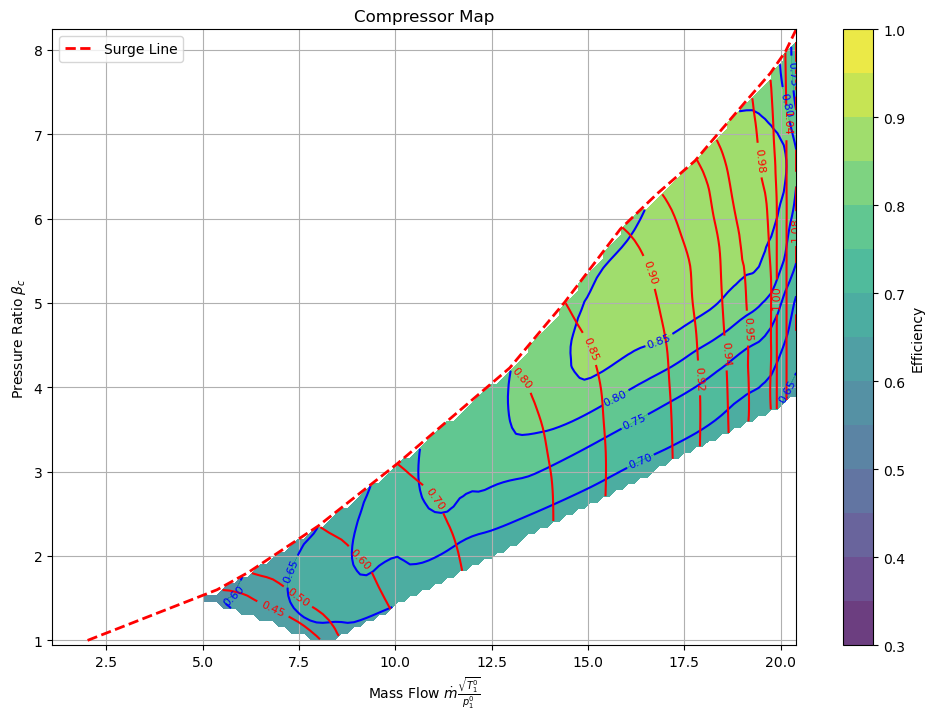

In [5]:
# -----------------------------
# Flatten arrays for interpolation
# -----------------------------
n_rows, n_cols = len(speed_comp), mf_comp.shape[1]

mf_flat_comp = mf_comp.flatten()
pr_flat_comp = pr_comp.flatten()          # use actual pressure ratio values
eff_flat_comp = eff_comp.flatten()
speed_flat_comp = np.repeat(speed_comp, n_cols)   # repeat speed along columns

# -----------------------------
# Regular grid for plotting
# -----------------------------

num_steps = 100

mf_grid_comp, pr_grid_comp = np.meshgrid(
    np.linspace(mf_flat_comp.min(), mf_flat_comp.max(), num_steps),
    np.linspace(pr_flat_comp.min(), pr_flat_comp.max(), num_steps)
)

# -----------------------------
# Interpolation on grid
# -----------------------------
eff_grid_comp = griddata((mf_flat_comp, pr_flat_comp), eff_flat_comp, (mf_grid_comp, pr_grid_comp), method='cubic')
speed_grid_comp = griddata((mf_flat_comp, pr_flat_comp), speed_flat_comp, (mf_grid_comp, pr_grid_comp), method='cubic')

# -----------------------------
# Surge line mask
# -----------------------------
surge_numbers = surge_df.values.flatten()
n = len(surge_numbers)//2
surge_X, surge_Y = surge_numbers[:n], surge_numbers[n:]
surge_interp = interp1d(surge_X, surge_Y, bounds_error=False, fill_value="extrapolate")
Y_grid_surge = surge_interp(mf_grid_comp[0,:])
Y_grid_mask = pr_grid_comp <= Y_grid_surge[np.newaxis, :]   # broadcast mask

# Apply mask
eff_grid_mask_comp = np.where(Y_grid_mask, eff_grid_comp, np.nan)
speed_grid_mask_comp = np.where(Y_grid_mask, speed_grid_comp, np.nan)


# -----------------------------
# Iso-efficiency contour
# -----------------------------
eff_levels = np.arange(0.3, 1.01, 0.05)
plt.figure(figsize=(12,8))
CF = plt.contourf(mf_grid_comp, pr_grid_comp, eff_grid_mask_comp, levels=eff_levels, cmap="viridis", alpha=0.8)
plt.colorbar(CF, label="Efficiency")
CS_eff = plt.contour(mf_grid_comp, pr_grid_comp, eff_grid_mask_comp, levels=eff_levels, colors='blue', linewidths=1.5)
plt.clabel(CS_eff, inline=True, fontsize=8, fmt="%.2f")

# -----------------------------
# Surge line plot
# -----------------------------
plt.plot(surge_X, surge_Y, 'r--', linewidth=2, label='Surge Line')

# -----------------------------
# Iso-N contour
# -----------------------------
N_levels = np.array([0.45, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.92, 0.94, 0.955, 0.98, 1.0, 1.04, 1.08])
cs = plt.contour(mf_grid_comp, pr_grid_comp, speed_grid_mask_comp, levels=N_levels, colors='r')
plt.clabel(cs, inline=True, fontsize=8, fmt="%1.2f")

# -----------------------------
# Labels and formatting
# -----------------------------
plt.xlabel(r"Mass Flow $\dot m \frac{\sqrt{T_1^0}}{p_1^0}$")
plt.ylabel(r"Pressure Ratio $\beta_c$")
plt.title("Compressor Map")
plt.grid(True)
plt.legend()
plt.show()


In [6]:
mf_grid_comp_opt = np.zeros((len(speed_turb), num_steps), dtype = np.float64)
pr_grid_comp_opt = np.zeros((len(speed_turb), num_steps), dtype  = np.float64)
eff_grid_comp_opt = np.zeros((len(speed_turb), num_steps), dtype = np.float64)

N_turb_levels_for_fitting_with_comp = np.linspace(N_levels.min(), N_levels.max(), len(speed_turb))


for i, N in enumerate(N_turb_levels_for_fitting_with_comp):
    mf_grid_comp_N = np.where(np.isclose(speed_grid_mask_comp, N, atol = 1e-2, rtol = 1e-5), mf_grid_comp, np.nan)
    pr_grid_comp_N = np.where(np.isclose(speed_grid_mask_comp, N, atol = 1e-2, rtol = 1e-5), pr_grid_comp, np.nan)
    eff_grid_comp_N = np.where(np.isclose(speed_grid_mask_comp, N, atol = 1e-2, rtol = 1e-5), eff_grid_comp, np.nan)

    mask_valid = ~np.isnan(pr_grid_comp_N)
    mf_vals_comp_N = mf_grid_comp_N[mask_valid]
    pr_vals_comp_N = pr_grid_comp_N[mask_valid]
    eff_vals_comp_N = eff_grid_comp_N[mask_valid]

    sort_idx = np.argsort(pr_vals_comp_N) 
    pr_sorted = pr_vals_comp_N[sort_idx]
    mf_sorted = mf_vals_comp_N[sort_idx]
    eff_sorted = eff_vals_comp_N[sort_idx]

    pr_sorted, unique_idx = np.unique(pr_sorted, return_index=True)
    mf_sorted = mf_sorted[unique_idx]
    eff_sorted = eff_vals_comp_N[unique_idx]

    pr_uniform = np.linspace(pr_sorted.min(), pr_sorted.max(), num_steps)
  
    mf_interp = interp1d(pr_sorted, mf_sorted, kind='linear', fill_value="extrapolate")
    eff_interp = interp1d(pr_sorted, eff_sorted, kind='linear', fill_value="extrapolate")
    
    x_data = pr_uniform
    y_data = mf_interp(pr_uniform)
    z_data = eff_interp(pr_uniform)
    
    degree = 2
    coeffs_mf = np.polyfit(x_data, y_data, degree)
    coeffs_eff = np.polyfit(x_data, z_data, degree)

    mf_grid_comp_opt[i,:] = np.polyval(coeffs_mf, x_data)
    eff_grid_comp_opt[i, :] = np.polyval(coeffs_eff, x_data)

    pr_grid_comp_opt[i,:] = pr_uniform

# for i, eff in enumerate()


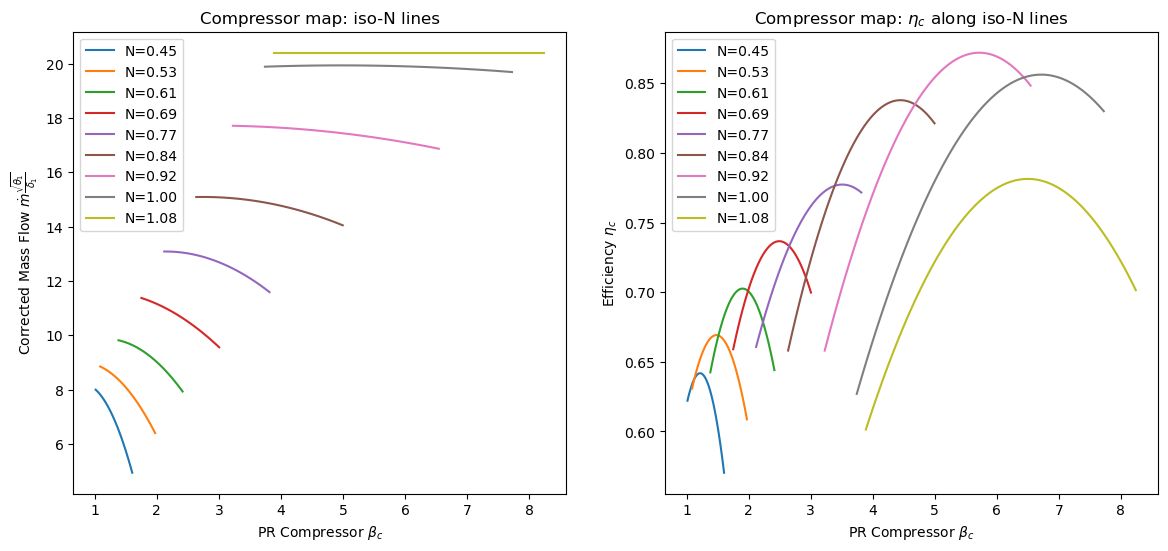

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6) )  
for i, N in enumerate(N_turb_levels_for_fitting_with_comp):
    axes[0].plot(pr_grid_comp_opt[i,:], mf_grid_comp_opt[i,:], label=f"N={N:.2f}")
axes[0].set_xlabel(r"PR Compressor $\beta_c$")
axes[0].set_ylabel(r"Corrected Mass Flow $\dot m \frac{\sqrt{\theta_1}}{\delta_1}$")
axes[0].set_title("Compressor map: iso-N lines")
axes[0].legend()

for i, N in enumerate(N_turb_levels_for_fitting_with_comp):
    axes[1].plot(pr_grid_comp_opt[i,:], eff_grid_comp_opt[i,:], label=f"N={N:.2f}")
axes[1].set_xlabel(r"PR Compressor $\beta_c$")
axes[1].set_ylabel(r"Efficiency $\eta_c$")
axes[1].set_title(r"Compressor map: $\eta_c$ along iso-N lines")
axes[1].legend()


### Turbine map

In [8]:
pr_dense_turb = np.linspace(pr_turb_min, pr_turb_max, num_steps)
pr_dense_grid_turb = np.tile(pr_dense_turb, (len(speed_turb), 1))                                                 

mf_dense_grid_turb = np.zeros_like(pr_dense_grid_turb)
eff_dense_grid_turb = np.zeros_like(pr_dense_grid_turb)

for i, isoN in enumerate(speed_turb):
    mf_isoN = mf_turb[i, :]
    mf_interpolator_turb = interp1d(pr_turb, mf_turb[i, :], kind = 'cubic')
    mf_dense_grid_turb[i, :] = mf_interpolator_turb(pr_dense_turb)

    eff = eff_turb[i, :]
    eff_interpolator_turb = interp1d(pr_turb, eff_turb[i, :], kind = 'cubic')
    eff_dense_grid_turb[i, :] = eff_interpolator_turb(pr_dense_turb)


Text(0.5, 1.0, 'Turbine map: efficiency heat map')

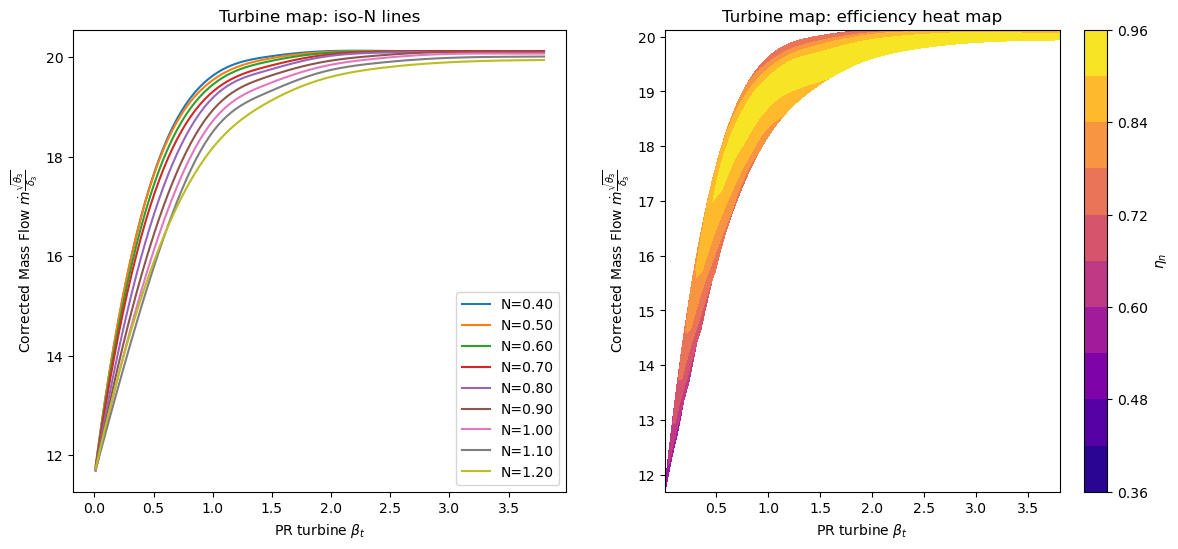

In [9]:

fig, axes = plt.subplots(1, 2, figsize=(14, 6) )  # 1 row, 2 columns
for i, N in enumerate(speed_turb):
    axes[0].plot(pr_dense_grid_turb[i,:], mf_dense_grid_turb[i,:], label=f"N={N:.2f}")
axes[0].set_xlabel(r"PR turbine $\beta_t$")
axes[0].set_ylabel(r"Corrected Mass Flow $\dot m \frac{\sqrt{\theta_3}}{\delta_3}$")
axes[0].set_title("Turbine map: iso-N lines")
axes[0].legend()

lines1 = axes[1].contourf(pr_dense_grid_turb, mf_dense_grid_turb, eff_dense_grid_turb, levels=10, cmap = 'plasma')
cbar1 = fig.colorbar(lines1 , ax=axes[1], label= r'$\eta_n$')
axes[1].set_xlabel(r'PR turbine $\beta_t$')
axes[1].set_ylabel(r'Corrected Mass Flow $\dot m \frac{\sqrt{\theta_3}}{\delta_3}$')
axes[1].set_title(r'Turbine map: efficiency heat map')


### Nozzle map

In [10]:
# ============================================================
# DATI NOZZLE
# ============================================================
A_out = 0.3 ** 2 * np.pi     # [m^2]
A_in = 0.45 ** 2 * np.pi

gamma = 1.33    # [-]
R = 287.0      # [J / kg / K]
p_amb = 101325 # [Pa]

# Tt1 = T_amb
# Tt2 = Tt1 * ( 1 + (beta_comp ** ((gamma - 1) / (gamma)) - 1) / eta_comp)
# Tt3 = calculate_T3_tot(Tt2, alpha = alpha0, max_iter = 5, tol = 1e-4)
# Tt4 = Tt3 * ( 1 - eta_turb * ( 1 - PR_turb ** (- (gamma - 1)/(gamma)) ) )
Tt4 = 800 # It actually cancels out in the mass flow correction, so you can also fix a random value

T_ref = 288

p_over_pt_crit = p_over_pt_from_M(1, gamma)
pr_crit_nozz = 1.0 / p_over_pt_crit

pr_nozz = np.append(np.linspace(1.0, pr_crit_nozz, int(num_steps / (10 / 8))), np.linspace(pr_crit_nozz-0.00001, 5, int(num_steps / (10 / 2))))
pt_vals = pr_nozz * p_amb
mf_nozz = np.zeros_like(pr_nozz)

for i, pt_i in enumerate(pt_vals):
    p_ratio = p_amb / pt_i
    if p_ratio < p_over_pt_crit: # Careful! It's p_over_pt ~ 0.5 not pt_over_p ~ 1.85 
        M_exit = 1.0
        mass_flow_area, _ = mass_flow_per_area_from_M(pt_i, Tt4, M_exit, gamma, R)
        mf_nozz[i] = A_out * mass_flow_area * np.sqrt(Tt4/T_ref) / (pt_i / p_amb)
    else:
        
        M_root = M_from_p_over_pt(p_ratio, gamma)
        mass_flow_area, _ = mass_flow_per_area_from_M(pt_i, Tt4, M_root, gamma, R)
        mf_nozz[i] = A_out * mass_flow_area *  np.sqrt(Tt4/T_ref) / (pt_i / p_amb)

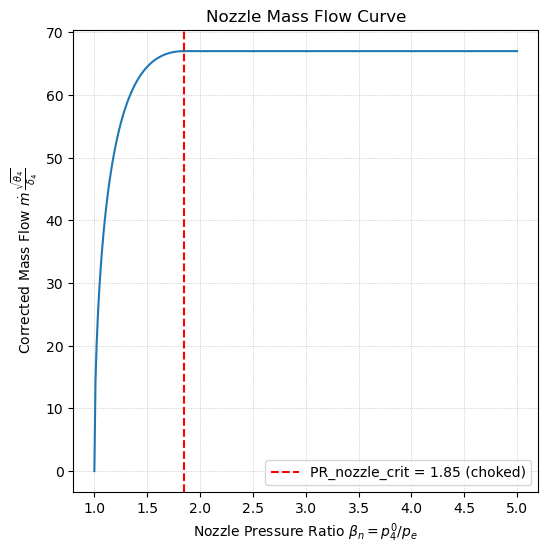

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(6,6))

# --- Nozzle Curve ---
axes.plot(pr_nozz, mf_nozz, color='tab:blue')
axes.axvline(pr_crit_nozz, linestyle='--', color='red',
                label=f'PR_nozzle_crit = {pr_crit_nozz:.2f} (choked)')
axes.set_xlabel(r'Nozzle Pressure Ratio $\beta_n = p_4^0 / p_e$')
axes.set_ylabel(r'Corrected Mass Flow $\dot{m} \, \frac{\sqrt{\theta_4}}{\delta_4}$')
axes.set_title('Nozzle Mass Flow Curve')
axes.grid(True, linestyle=':', linewidth=0.5)
axes.legend()

### Turbine-Nozzle map

In [12]:
mf_crit_nozz = mf_nozz[-1]

pr_dense_turb_nozz = np.zeros_like(mf_dense_grid_turb)
mf_dense_turb_nozz = np.zeros_like(mf_dense_grid_turb)

for i, PRt in enumerate(pr_dense_turb):
    for j, Nt in enumerate(speed_turb):

        # Set a point on the Turbine map (PRt and Nt are already selected by the for cycles):
        mf_match_turb = mf_dense_grid_turb[j, i] # the correct indexing is mf_match_turb[PR_idx, N_idx]
        eta_match_turb = eff_dense_grid_turb[j, i]

        # Calculate the corrected mass flow that would go through the nozzle
        mf_match_nozzle = mf_match_turb * PRt * np.sqrt(( 1 - eta_match_turb * ( 1 - PRt ** ( - (gamma - 1)/(gamma) ) ) ) )

        if mf_match_nozzle <= mf_crit_nozz:
            # then the selected point is fine, the turbine is not blocked

            # The overall PR is the product between the two
            idx_PRn = np.abs(mf_nozz - mf_match_nozzle).argmin()
            pr_dense_turb_nozz[j, i] = PRt * pr_nozz[idx_PRn]

            # The mass flowing is corrected  with pre-turbine params
            mf_dense_turb_nozz[j, i] = mf_match_turb

        elif np.isclose(mf_match_nozzle, mf_crit_nozz, rtol = 0.05, atol = 2): 
            # The nozzle is choked, the turbine is blocked: the maximum mass flow is the one allowed by the nozzle, corrected with pre-turbine quantities by convention
            mf_dense_turb_nozz[j, i] = mf_crit_nozz / PRt / np.sqrt(( 1 - eta_match_turb * ( 1 - PRt ** ( - (gamma - 1)/(gamma) ) ) ) )

            # Now the Nozzle has an increase in PR without letting more mass to flow
            idx_PRn = np.abs(mf_nozz - mf_match_nozzle).argmin() 
            pr_dense_turb_nozz[j, i] = PRt * pr_nozz[idx_PRn]
        
        else:
            mf_dense_turb_nozz[j, i] = np.nan
            pr_dense_turb_nozz[j, i] = np.nan

In [13]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# --- single-cell animation (uses your arrays as-is) ---
fig, ax = plt.subplots(figsize=(14, 6))

# two lines (turbine+nozzle and turbine-only)
line1, = ax.plot([], [], lw=2, label='Turbine + Nozzle')
line2, = ax.plot([], [], lw=2, linestyle='--', label='Turbine')

ax.set_xlabel(r"PR turbine + nozzle $\beta_t \beta_n$")
ax.set_ylabel(r"Corrected Mass Flow $\dot m \frac{\sqrt{\theta_3}}{\delta_3}$")
ax.legend()

# determine axis limits from your data (robust to NaNs)
xmin = np.nanmin([np.nanmin(pr_dense_turb_nozz), np.nanmin(pr_dense_grid_turb)])
xmax = np.nanmax([np.nanmax(pr_dense_turb_nozz), np.nanmax(pr_dense_grid_turb)])
ymin = np.nanmin([np.nanmin(mf_dense_turb_nozz), np.nanmin(mf_dense_grid_turb)])
ymax = np.nanmax([np.nanmax(mf_dense_turb_nozz), np.nanmax(mf_dense_grid_turb)])
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return line1, line2

def update(i):
    # i is the idx_plot (0..len(speed_turb)-1)
    line1.set_data(pr_dense_turb_nozz[i, :], mf_dense_turb_nozz[i, :])
    line2.set_data(pr_dense_grid_turb[i, :], mf_dense_grid_turb[i, :])
    ax.set_title(f"Comparison between iso-N lines, N={speed_turb[i]:.2f}  ({i+1}/{len(speed_turb)})")
    return line1, line2

ani = FuncAnimation(fig, update, frames=range(len(speed_turb)),
                    init_func=init, blit=False, interval=800, repeat=True)

# Try to embed as JS first (works well in classic Jupyter Notebook)
try:
    js = ani.to_jshtml()
    plt.close(fig)   # avoid double-render
    display(HTML(js))
except Exception:
    # fallback to HTML5 video (may require ffmpeg)
    try:
        vid = ani.to_html5_video()
        plt.close(fig)
        display(HTML(vid))
    except Exception:
        # last resort: show first frame and raise a helpful message
        print("Could not create embedded animation (to_jshtml/to_html5_video failed). Showing the first frame instead.")
        update(0)
        plt.show()


## Turbine-Nozzle + Compressor Matching

1. Take a point on the compressor map and retrieve the associated values of corrected speed `N_corr` and compressor efficiency `η_c`.  
2. Assume a trial value for the temperature ratio `T3/T1`.  
3. Use this assumed `T3/T1` to retrieve a point on the turbine map, applying the congruence equations (mass and rpm conservations).  
4. Check the pressure congruence between compressor outlet and turbine inlet/outlet.  
5. Iterate adjusting `T3/T1` until pressure congruence is satisfied.


In [14]:
# Constants definition

epsilon_b = 0.99 # [-] Combustor pressure ratio TODO: implement combustor map

epislon_d = 0.99 # [-] Air intake pressure ratio TODO: implement air intake map

M0 = 0.5 # [-] Assumed aircraft Mach number (actually is an input from the game)

gamma = 1.4 # [-] Air specific heat ratio cp/cv


In [ ]:
valid_mask = ~np.isnan(mf_grid_comp_opt)
valid_indices = list(zip(*np.where(valid_mask)))

best_temp_ratios = np.full(mf_grid_comp_opt.shape, np.nan)
best_differences = np.full(mf_grid_comp_opt.shape, np.nan)

total_points = len(valid_indices)

differences = []
temp_ratios_list = []

mf_turb_flat = mf_dense_grid_turb.flatten()
pr_turb_flat = pr_dense_turb_nozz[0]

print(pr_dense_turb_nozz)
speed_turb_flat = N_turb_levels_for_fitting_with_comp
eff_flat = eff_dense_grid_turb.flatten()


for count, (i, j) in enumerate(valid_indices, start=1):
# for count, (i, j) in enumerate(valid_indices[500:600], start=1):

    mf_curve = mf_dense_turb_nozz[i, :]
    N_curve = np.full_like(mf_curve, speed_turb[i])  # stessa lunghezza, N costante


    print(f"Processing point {count}/{total_points} -> index (i={i}, j={j})")

    differences = []
    temp_ratios_list = []
    for temp_ratio in np.arange(0.9, 3.9, 0.05):

        # mf and N set by the compressor but corrected with turbine params:
        mf_cons_turbnozz = mf_grid_comp_opt[i, j] / pr_grid_comp_opt[i, j] / epsilon_b * np.sqrt(temp_ratio)
        N_cons_turbnozz =  speed_turb_flat[i]  / np.sqrt(temp_ratio)


        # now we have to find where these mf and N are on the turbine map
        
        idx_min = np.nanargmin(distances)

        # # Calculate RHS
        LHS_pressure_eq = (1 + (gamma - 1) / 2 * M0 ** 2) ** (gamma / (gamma - 1)) * epislon_d * pr_grid_comp_opt[i, j]
        RHS_pressure_eq =  pr_turb_flat[idx_min] / epsilon_b

        print(pr_turb_flat[idx_min])

        # and compare it with LHS
        temp_ratios_list.append(temp_ratio)

        differences.append(abs(LHS_pressure_eq - RHS_pressure_eq))

    # Salva il temp_ratio con differenza minima
    min_idx = np.argmin(differences)
    best_temp_ratios[i, j] = temp_ratios_list[min_idx]
    best_differences[i, j] = differences[min_idx]
    # clear_output(wait = True)

[[0.01850604 0.08935241 0.16019878 0.23104515 0.30189152 0.37273789
  0.44358425 0.51443062 0.58527699 0.65612336 0.72696973 0.7978161
  0.86866246 0.93950883 1.0103552  1.08120157 1.15204794 1.22289431
  1.29374068 1.36458704 1.43543341 1.50627978 1.57712615 1.64797252
  1.71881889 1.78966525 1.86051162 1.93135799 2.00220436 2.07305073
  2.1438971  2.21474346 2.28558983 2.3564362  2.42728257 2.49812894
  2.56897531 2.63982168 2.71066804 2.78151441 2.85236078 2.92320715
  2.99405352 3.06489989 3.13574625 3.20659262 3.27743899 3.34828536
  3.41913173 3.4899781  3.56082447 3.63167083 3.7025172  3.77336357
  3.84420994 3.91505631 3.98590268 4.05674904 4.12759541 4.19844178
  4.26928815 4.34013452 4.41098089 4.48182725 4.55267362 4.62351999
  4.69436636 4.76521273 4.8360591  4.90690547 4.97775183 5.0485982
  5.11944457 5.19029094 5.26113731 5.33198368 5.40283004 5.47367641
  5.54452278 5.61536915 5.68621552 5.75706189 5.82790826 5.89875462
  5.96960099 6.04044736 6.11129373 6.1821401  6.25

KeyboardInterrupt: 

In [30]:
print(best_temp_ratios)
print(best_differences)

[[3.75 3.8  3.85 3.7  3.75 3.8  3.85 3.65 3.7  3.8  3.85 3.6  3.65 3.75
  3.8  3.85 3.6  3.65 3.7  3.75 3.85 3.55 3.6  3.65 3.7  3.8  3.85 3.55
  3.6  3.65 3.7  3.75 3.8  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9
  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9
  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9
  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9
  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9
  0.9  0.9 ]
 [3.75 3.8  3.85 3.75 3.8  3.85 3.7  3.8  3.85 3.65 3.75 3.8  3.85 3.65
  3.7  3.8  3.85 3.6  3.7  3.75 3.8  3.55 3.6  3.65 3.75 3.8  3.85 3.55
  3.6  3.65 3.75 3.8  3.85 0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9
  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9
  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9
  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9
  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9

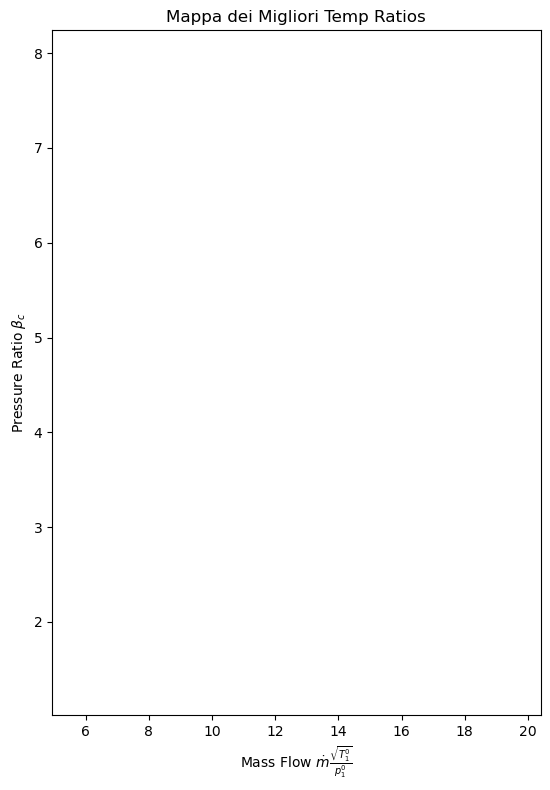

In [17]:
plt.figure(figsize=(12,8))
# CF = plt.contourf(mf_grid_comp, pr_grid_comp, eff_grid_mask_comp, levels=eff_levels, cmap="viridis", alpha=0.8)
# plt.colorbar(CF, label="Efficiency")
# CS_eff = plt.contour(mf_grid_comp, pr_grid_comp, eff_grid_mask_comp, levels=eff_levels, colors='blue', linewidths=1.5)
# plt.clabel(CS_eff, inline=True, fontsize=8, fmt="%.2f")

# # -----------------------------
# # Surge line plot
# # -----------------------------
# plt.plot(surge_X, surge_Y, 'r--', linewidth=2, label='Surge Line')

# # -----------------------------
# # Iso-N contour
# # -----------------------------
# N_levels = np.array([0.45, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.92, 0.94, 0.955, 0.98, 1.0, 1.04, 1.08])
# cs = plt.contour(mf_grid_comp, pr_grid_comp, speed_grid_mask_comp, levels=N_levels, colors='r')
# plt.clabel(cs, inline=True, fontsize=8, fmt="%1.2f")

# -----------------------------
# iso-Temperature ratio contour
# -----------------------------
temp_ratio_levels = np.arange(0, 4, 0.1)
CS_eff = plt.contour(mf_grid_comp_opt, pr_grid_comp_opt, best_temp_ratios, levels=temp_ratio_levels, colors='black', linewidths=1.5)
plt.clabel(CS_eff, inline=True, fontsize=8, fmt="%.2f")


plt.title('Mappa dei Migliori Temp Ratios')
plt.xlabel(r"Mass Flow $\dot m \frac{\sqrt{T_1^0}}{p_1^0}$")
plt.ylabel(r"Pressure Ratio $\beta_c$")

plt.gca().set_aspect(3)
plt.tight_layout()
plt.show()